In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_29380/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Data

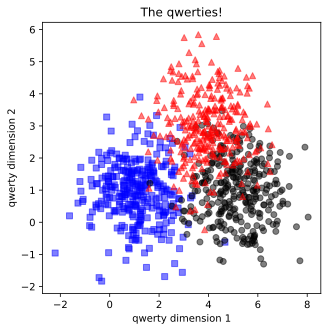

In [2]:
# Parameters
n_per_clust = 300
blur        = 1
A           = [1, 1]
B           = [5, 1]
C           = [4, 3]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

# Concatanate into a matrix
data_np   = np.hstack(tup=(a, b, c)).T

# True labels
labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                           np.ones(shape=(n_per_clust)),
                           1 + np.ones(shape=(n_per_clust))))

# Convert to a pytorch tensor
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=0.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=0.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=0.5)

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
train_batch_size = 16
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset,  batch_size=test_batch_size)

# How many batches are there?
print(f'There are {len(train_loader)} batches, each with {train_batch_size} samples')

There are 50 batches, each with 16 samples


# Model

In [4]:
def create_the_qwety_net(momentum):
    class qwerty_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear (2, 8)

            # Hidden layer
            self.fc1 = nn.Linear(8, 8)

            # Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = self.output(x)

            return x
        
    # Create the model instance
    net = qwerty_net()
    
    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01, momentum=momentum)

    return net, loss_func, optimizer

In [5]:
# Confirm that the optimizer has momentum
optim = create_the_qwety_net(momentum=0.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

# Training

In [16]:
num_epochs = 50

def train_the_model(momentum):
  
  net, loss_func, optimizer = create_the_qwety_net(momentum)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()))

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      # pred_labels = torch.argmax(net(X), axis=1)
      y_hat = net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()))

  # Function output
  return train_acc, test_acc, losses, net

# Now for the experiment!

In [17]:
# Momentum values to use
momentums = [0, 0.5, 0.9, 0.95, 0.999]

# Initialize results matrix
results = np.zeros(shape=(num_epochs, len(momentums), 3))

# Test all momentum values on the same data (different model instances)
for idx, momentum_i in enumerate(momentums):
    train_acc, test_acc, losses, net = train_the_model(momentum_i)
    results[:, idx, 0] = losses
    results[:, idx, 1] = train_acc
    results[:, idx, 2] = test_acc


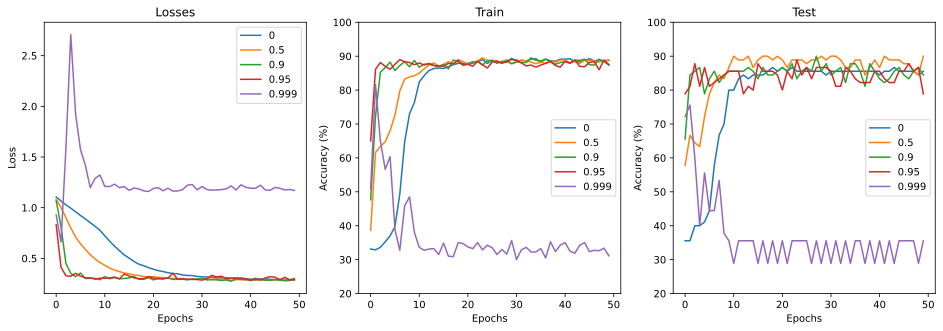

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

for i in range(3):
  ax[i].plot(results[:, :, i])
  ax[i].legend(momentums)
  ax[i].set_xlabel('Epochs')

  if (i == 0):
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20, 100])
  
ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

# Additional explorations

In [ ]:
# 1) Now that you see the results across a broad range of beta (momentum) parameters, try re-running the experiment
#    using a narrower range. For example, you don't need to test b=0 or b=.999.
# 
# 2) The beta parameter multiplies the learning rate in the computation (see formula in slides). That means that these
#    results will interact with the learning rate. Repeat the experiment using a different learning rate.
# 
# 3) If you wanted to test the relationship between momentum and learning rate in a full parametric experiment, how would
#    you set it up? Would you store the loss/accuracy over all epochs? 
# 